<AxesSubplot:>

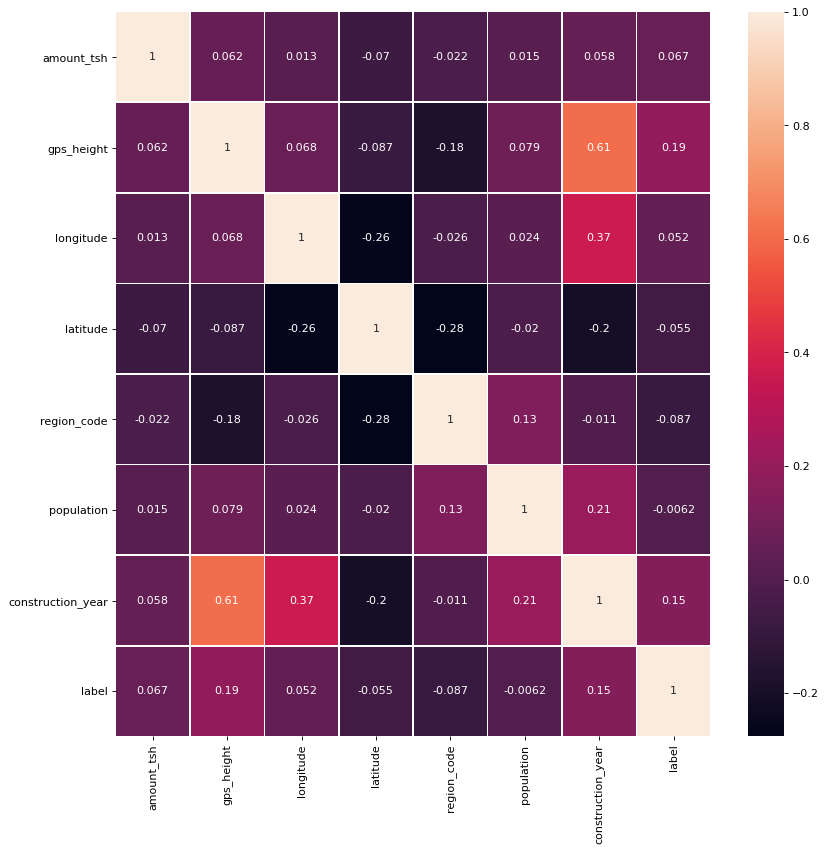

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(12, 12), dpi=80)
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.tree import ExtraTreeClassifier
from sklearn import preprocessing
import seaborn as sns
import pandas as pd

def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')    
    return dataset

X_train = load_dataset("X_train_raw.csv")
y_train =load_dataset("y_train_raw.csv")
X_test=load_dataset("X_test_raw.csv")

#Fem un merge de les x del trainset amb les y per poder tenir el label juntament amb les variables per a entrenar

XY_train = X_train.merge(y_train,how='outer',left_index=True, right_index=True)

#Eliminem els valors nan
XY_train = XY_train.dropna()
y_train = y_train.dropna()
X_train = X_train.dropna()

#La nostre variable objectiu es categorica, per a mostrar el heatmap y estudiar la correlacio fem el seguent
label_dict = {"functional":2,"functional needs repair":1,"non functional":0}
XY_train["label"] = XY_train["status_group"].map(label_dict)

#Hi han variables que no aporten gaire info, per exemple region_code y district_code podrien ser redundants
# a mes la latitud y gps_height ja ens donen info de la posicio del pou, podriem considerar eliminar una o ambdues

#Si veiem les dades que ens proporcionen hi han moltes que son molt semblants(evitem posible overfiting)

X_train = X_train.drop(['waterpoint_type','source_class','permit','public_meeting','source','management','extraction_type','scheme_management','funder','date_recorded','basin','installer','payment_type','management_group', 'num_private', 'wpt_name', 
          'recorded_by', 'subvillage', 'scheme_name', 'region', 
          'quantity', 'water_quality', 'lga','ward', 'source_type', 'payment', 
          'waterpoint_type_group','extraction_type_group','extraction_type_class'],axis=1)

#Aquest merge ens serveix per fer el analisi de dades mes facilment comparant amb label
XY_train = XY_train.drop(['waterpoint_type','source_class','permit','public_meeting','source','management','extraction_type','scheme_management','funder','date_recorded','basin','installer','payment_type','management_group','status_group','id_x','id_y', 'num_private', 'wpt_name', 
          'recorded_by', 'subvillage', 'scheme_name', 'region', 
          'quantity', 'water_quality', 'lga','ward', 'source_type', 'payment', 
          'waterpoint_type_group','extraction_type_group','extraction_type_class'],axis=1)

X_test = X_test.drop(['waterpoint_type','source_class','permit','public_meeting','source','management','extraction_type','scheme_management','funder','date_recorded','basin','installer','payment_type','management_group','id', 'num_private', 'wpt_name', 
          'recorded_by', 'subvillage', 'scheme_name', 'region', 
          'quantity', 'water_quality', 'lga','ward', 'source_type', 'payment', 
          'waterpoint_type_group','extraction_type_group','extraction_type_class'],axis=1)


#La var objectiu es discreta, es pot entendre com 3 clases, un model classificador sera interesant
#Mostrem el pairplot per datamaining
#relacio = sns.pairplot(XY_train)
#print(relacio)

#Veiem que region_code i district_code tenen molta correlacio i aporten informacion massa semblant, eliminem la que menys
#correlacio te ambh la var objectiu
XY_train=XY_train.drop(['district_code'],axis=1)
X_test=X_test.drop(['district_code'],axis=1)
X_train=X_train.drop(['district_code'],axis=1)



correlacio=XY_train.corr()
sns.heatmap(correlacio, annot=True, linewidths=.5)




In [2]:
#Tractarem de algunes variables categoriques com quantity group y quality group mostrarles com a variables nuemriques(ordinal)
# ja que potencialment a millor qualitat o quantitat d'aigua mes probable que el pou sigui funcional

numeric_quality = {"good":3,"salty":2,"milky":2,"colored":2,"fluoride":2,"unknown":1}

XY_train["quality_group_code"]=0

for count,item in enumerate(XY_train.quality_group):
    XY_train["quality_group_code"][count] = numeric_quality[item]
   

X_test["quality_group_code"]=0
for count,item in enumerate(X_test.quality_group):
    X_test["quality_group_code"][count]  = numeric_quality[item]


#Eliminem la antiga columna
del XY_train["quality_group"]
del X_test["quality_group"]




#El mateix per quantity
numeric_quantity = {"enough":3,"insufficient":2,"dry":2,"seasonal":2,"unknown":1}
XY_train["quantity_group_code"]=0
for count,item in enumerate(XY_train.quantity_group):
    XY_train["quantity_group_code"][count] = numeric_quantity[item]
 
    
X_test["quantity_group_code"]=0
for count,item in enumerate(X_test.quantity_group):
    X_test["quantity_group_code"][count] = numeric_quantity[item]

#Eliminem la antiga columna

del XY_train["quantity_group"]
del X_test["quantity_group"]

       
        
#correlacio=XY_train.corr()
#sns.heatmap(correlacio, annot=True, linewidths=.5)

XY_train.head()
      

<ipython-input-2-49bf1d6802b7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XY_train["quality_group_code"][count] = numeric_quality[item]
<ipython-input-2-49bf1d6802b7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["quality_group_code"][count]  = numeric_quality[item]
<ipython-input-2-49bf1d6802b7>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XY_train["quantity_group_code"][count] = numeric_quantity[item]
<ipython-i

,amount_tsh,gps_height,longitude,latitude,region_code,population,construction_year,label,quality_group_code,quantity_group_code
0,6000.0,1390,34.938093,-9.856322,11,109,1999,2,3,3
2,25.0,686,37.460664,-3.821329,21,250,2009,2,2,3
5,20.0,0,39.172796,-4.765587,4,1,2009,2,3,2
13,0.0,1368,37.092574,-3.181783,3,1,2009,2,3,3
14,0.0,0,34.364073,-3.629333,17,0,0,2,3,2


<AxesSubplot:>

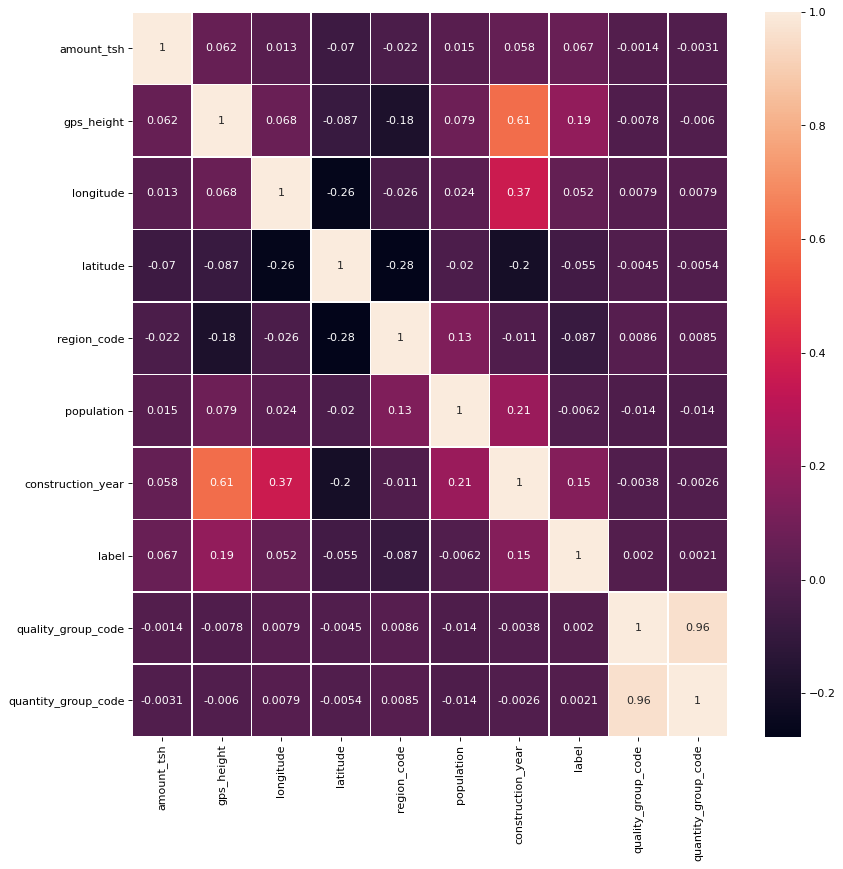

In [3]:
figure(figsize=(12, 12), dpi=80)
correlacio=XY_train.corr()
sns.heatmap(correlacio, annot=True, linewidths=.5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27813 entries, 0 to 59396
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   amount_tsh           27813 non-null  float64
 1   gps_height           27813 non-null  int64  
 2   longitude            27813 non-null  float64
 3   latitude             27813 non-null  float64
 4   region_code          27813 non-null  int64  
 5   population           27813 non-null  int64  
 6   construction_year    27813 non-null  int64  
 7   label                27813 non-null  int64  
 8   quality_group_code   27813 non-null  int64  
 9   quantity_group_code  27813 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 3.3 MB


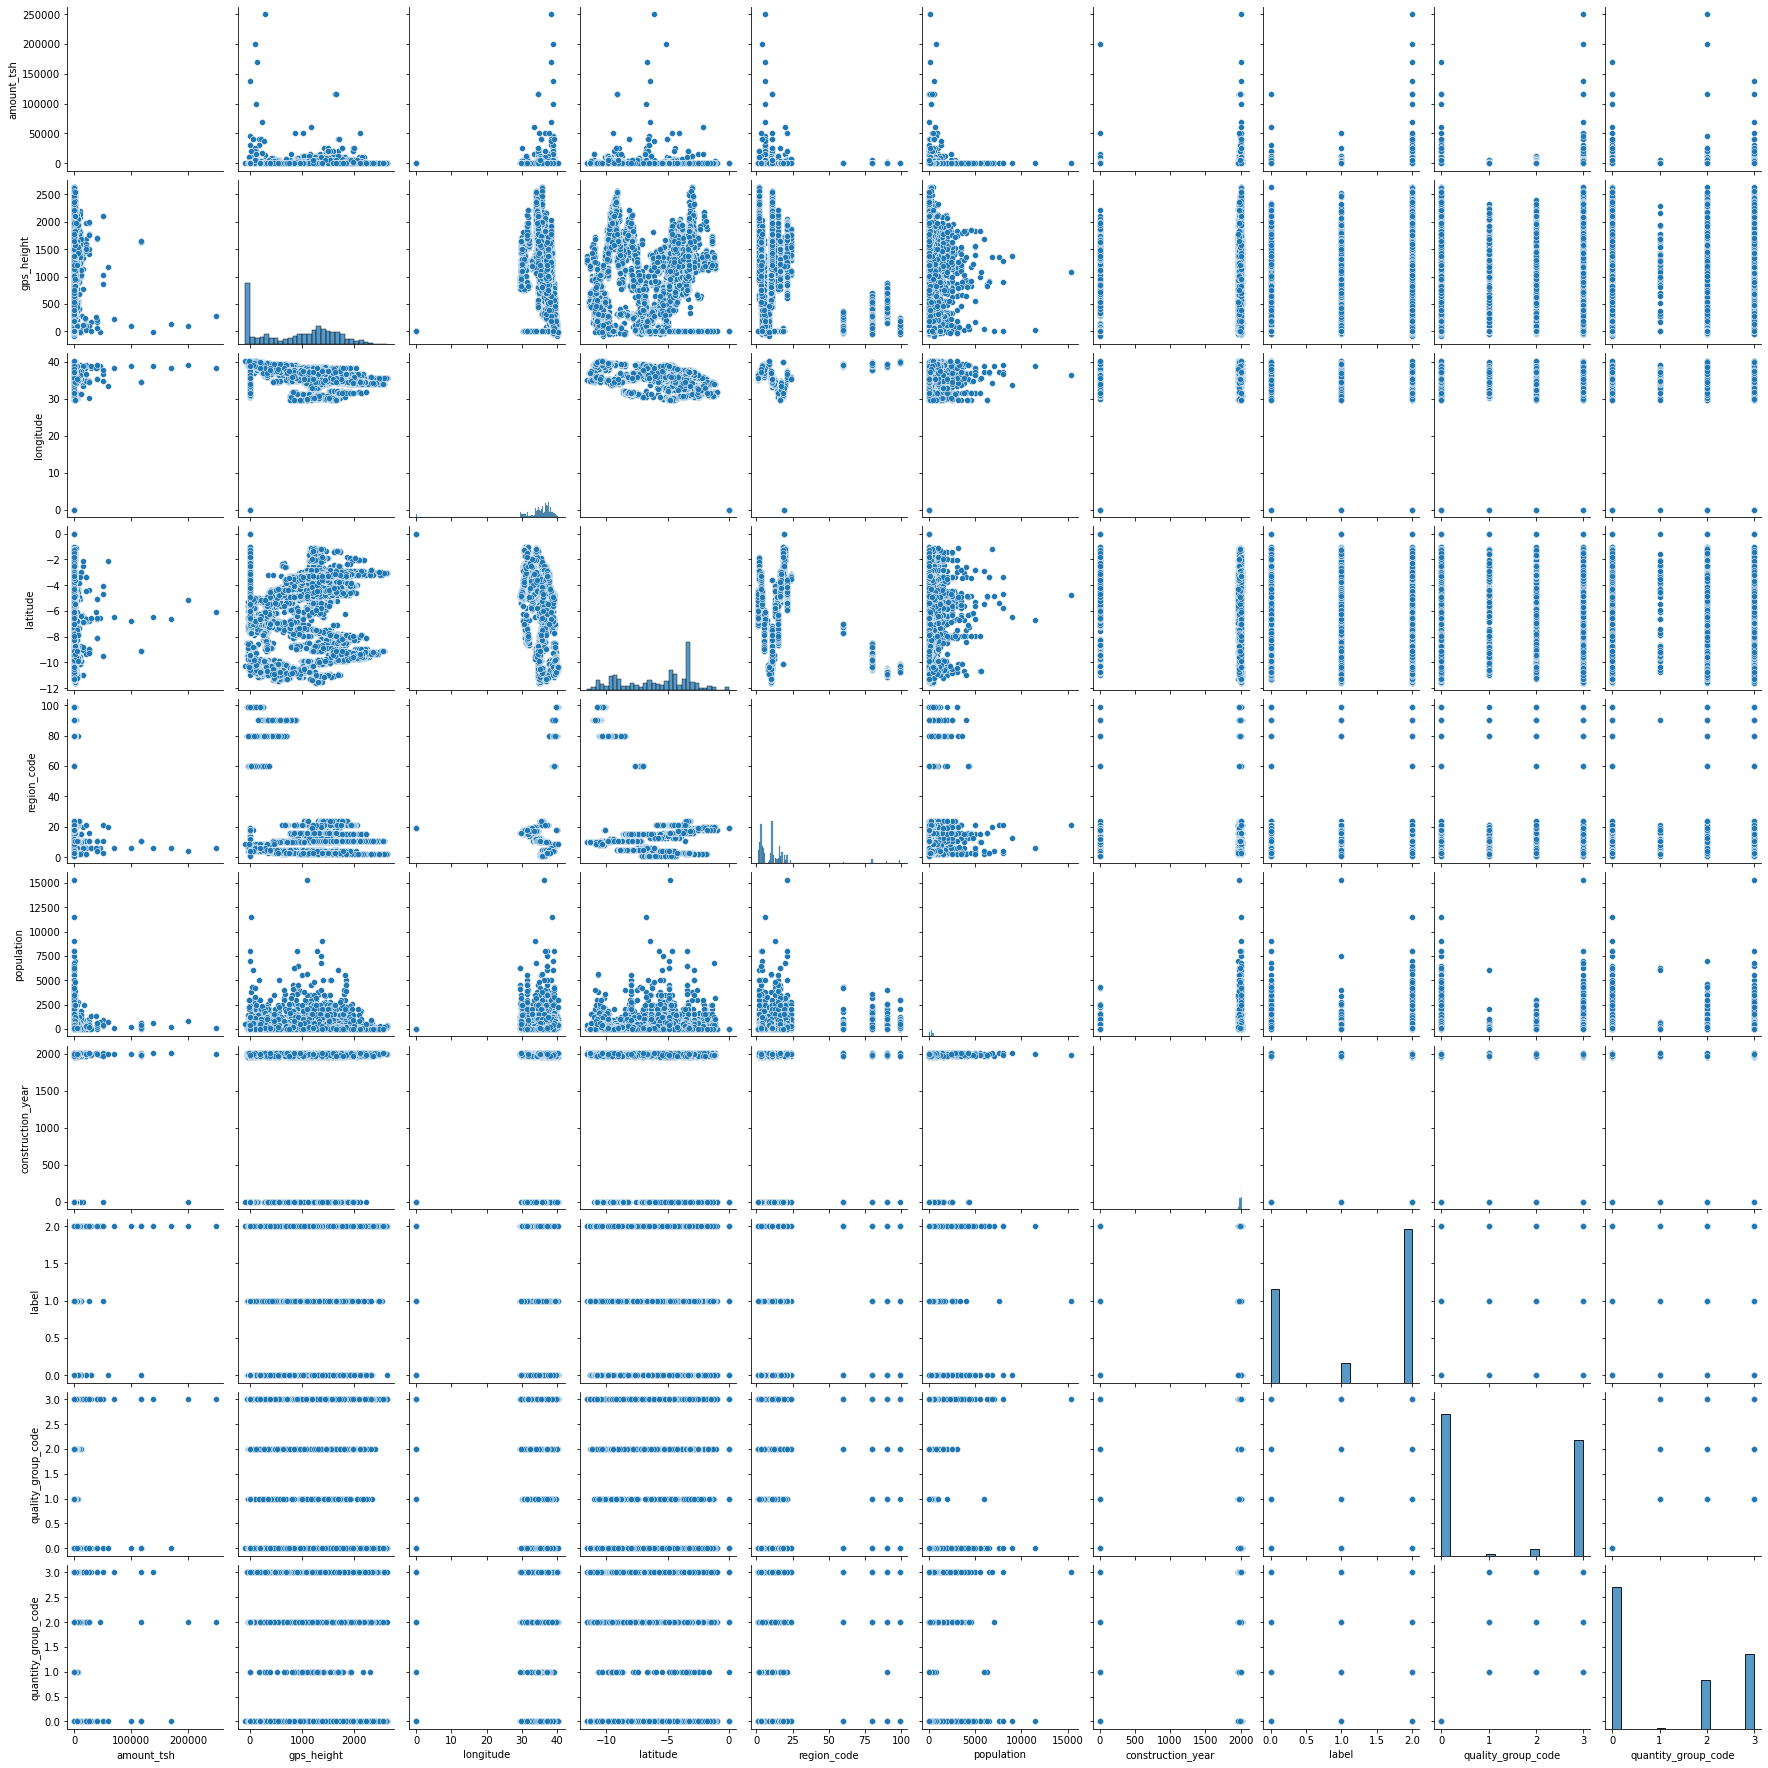

In [13]:
#info util(Revisar outliers de Population,latitude y amount_tsh)
XY_train.head()

XY_train.info()
XY_train.describe()

sns.pairplot(XY_train) #Com veiem en el pairplot no ens aporta gaire info por a la classificacio casi cap variable(una mica amount)


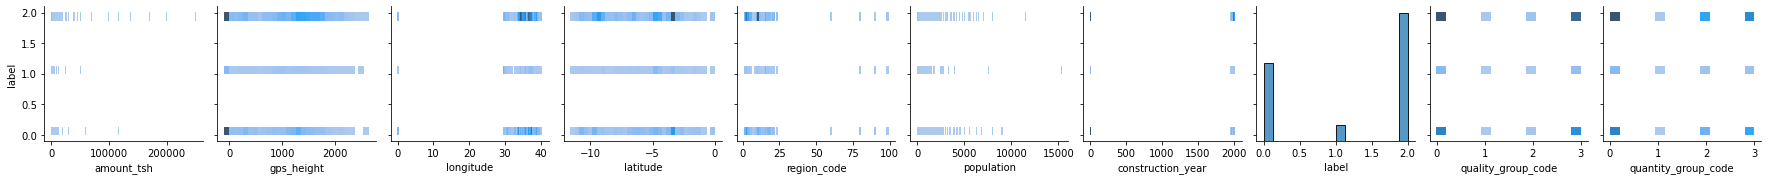

In [4]:
sns.pairplot(
    XY_train,
    y_vars=["label"], 
    kind="hist"
)

In [30]:
#Logistic Regressor (aprox 60% accuracy)

X = XY_train.drop("label",axis=1)
y=XY_train["label"]
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=0.8)
logireg = LogisticRegression(C=2.0, fit_intercept=True, penalty='l2', tol=0.001,max_iter=1000)
logireg.fit(x_t, y_t)

print ("Correct classification Logistic 80% of the data: ", logireg.score(x_v, y_v))

#Try standarize(aprox same result) Veiem que estandaritzar les dades ens dona el mateix resultat
scale= StandardScaler()
scaled_data = scale.fit_transform(X)

x_t, x_v, y_t, y_v = train_test_split(scaled_data, y, train_size=0.8)
logireg = LogisticRegression(C=2.0, fit_intercept=True, penalty='l2', tol=0.001)
logireg.fit(x_t, y_t)
print ("Correct classification Logistic 80% of the standarized data: ", logireg.score(x_v, y_v))



Correct classification Logistic 80% of the data:  0.5878123314758223
Correct classification Logistic 80% of the standarized data:  0.587273054107496


In [31]:
# KNN(aprox 67% accuracy)

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_t, y_t)
y_pred = knn.predict(x_v)

acc_knn = round(accuracy_score(y_v,y_pred) * 100, 2)
print ("Correct classification KNN 80% of the data: ",acc_knn)

Correct classification KNN 80% of the data:  66.35


In [29]:
# ExtraTreesClassifier(Probem un metode no utilitzat a practiques) (70% accuracy)

ETC = ExtraTreeClassifier(random_state=0)
ETC.fit(x_t, y_t)     
y_pred = ETC.predict(x_v)

acc_ETC = round(accuracy_score(y_v,y_pred) * 100, 2)
print ("Correct classification KNN 80% of the data: ",acc_ETC)


Correct classification KNN 80% of the data:  70.23
